In [1]:
#IMPORT THE LIBRARIES AND DATASET 

from datasets import load_dataset
import matplotlib.pyplot as plt
#SOLUTION IS BASED ON THE REFERENCE: https://huggingface.co/blog/fine-tune-vit

ds = load_dataset('beans')

ex = ds['train'][400]
ex

image = ex['image']
image

labels = ds['train'].features['labels']
labels

labels.int2str(ex['labels'])

Found cached dataset beans (C:/Users/Admin/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)


  0%|          | 0/3 [00:00<?, ?it/s]

'bean_rust'

Loading cached processed dataset at C:\Users\Admin\.cache\huggingface\datasets\beans\default\0.0.0\90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791\cache-661debf1fc5b8190.arrow
Loading cached processed dataset at C:\Users\Admin\.cache\huggingface\datasets\beans\default\0.0.0\90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791\cache-d9d8635069978cb1.arrow
Loading cached processed dataset at C:\Users\Admin\.cache\huggingface\datasets\beans\default\0.0.0\90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791\cache-9487341e98842d51.arrow


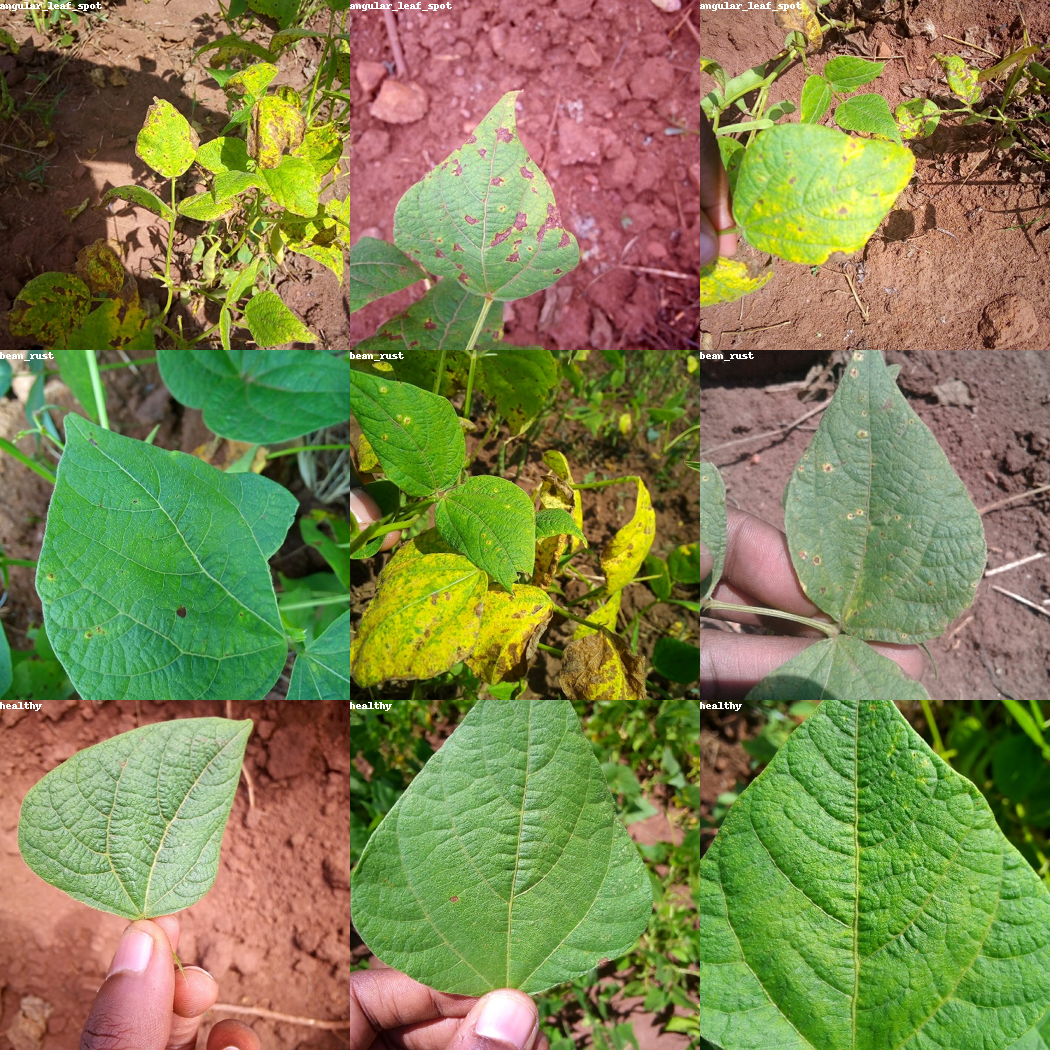

In [2]:
#PLOT THE IMAGES OF THE CLASSIFICATION PROBLEM 

import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.load_default()

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

In [3]:
# INITIALIZE THE TRANSFORMER MODEL AND TRANSFORM THE DATASET TO ACCEPT A BATCH OF DATA

from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)



feature_extractor(image, return_tensors='pt')

#%%

def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

process_example(ds['train'][0])

#%%


def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

#%%

prepared_ds = ds.with_transform(transform)

prepared_ds['train'][0:2]

C:\Users\Admin\anaconda3\envs\tf\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1843, -0.2471],
          [-0.6078, -0.6000, -0.5765,  ..., -0.0353, -0.0196, -0.2627],
          [-0.6314, -0.6314, -0.6078,  ..., -0.2314, -0.3647, -0.2235],
          ...,
          [-0.5373, -0.5529, -0.5843,  ..., -0.0824, -0.0431, -0.0902],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3098,  0.1843,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2627,  0.1608,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3647, -0.3255, -0.5686],
          [-0.7490, -0.7490, -0.7725,  ..., -0.5373, -0.6549, -0.5373],
          ...,
          [-0.7725, -0.7804, -0.8196,  ..., -0.2235, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1922,  0.3098,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0824,  0.2784,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3569, -0.7255],
          [-0

In [4]:
#INITIALIZE THE MODEL AND TRAINING CONFIGURATION

from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

#%%

from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  #fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
#DEFINE THE DATA COLLECTOR AND EVALUATION METRICS
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18656\1068789622.py:13: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [9]:
#TRAINING THE MODEL 

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)


trainer.train()

C:\Users\Admin\anaconda3\envs\tf\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.134800,0.226881,0.932331
200,0.042400,0.078516,0.969925


TrainOutput(global_step=260, training_loss=0.13706077684003573, metrics={'train_runtime': 5890.4557, 'train_samples_per_second': 0.702, 'train_steps_per_second': 0.044, 'total_flos': 3.205097416476426e+17, 'train_loss': 0.13706077684003573, 'epoch': 4.0})

In [10]:
# PREDICTIONS

outputs = trainer.predict(prepared_ds["test"])

print(outputs.metrics)

{'test_loss': 0.07864579558372498, 'test_accuracy': 0.9765625, 'test_runtime': 72.9599, 'test_samples_per_second': 1.754, 'test_steps_per_second': 0.219}


              precision    recall  f1-score   support

     class 0       1.00      0.95      0.98        43
     class 1       0.93      1.00      0.97        43
     class 2       1.00      0.98      0.99        42

    accuracy                           0.98       128
   macro avg       0.98      0.98      0.98       128
weighted avg       0.98      0.98      0.98       128



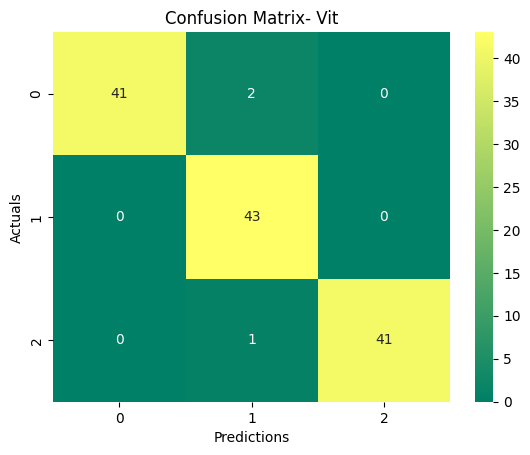

In [11]:
# CONFUSION MATRIX AND PERFORMANCE METRICS 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics


y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

# Print the confusion matrix using Matplotlib
cm= metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='summer');  
# labels, title and ticks
ax.set_xlabel('Predictions');ax.set_ylabel('Actuals'); 
ax.set_title('Confusion Matrix- Vit'); 


from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))